In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE

In [3]:
# Dataset: The dataset used for this project is sourced from Kaggle's Recipe Site Traffic Dataset.
# Please visit the link for more details on the dataset: https://www.kaggle.com/datasets/nourelimane/recipe-site-traffic-2212

# Read the CSV file from Google Drive
df = pd.read_csv(r'C:\Users\cerde\projects\recipe\data\recipe_site_traffic.csv')

Data Validation

In [4]:
# Explore the data
pd.set_option('display.max_columns', None)
print(df.shape)
print(df.info())
print(df.head())

(947, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
None
   recipe  calories  carbohydrate  sugar  protein   category servings  \
0       1       NaN           NaN    NaN      NaN       Pork        6   
1       2     35.48         38.56   0.66     0.92     Potato        4   
2       3    914.28         42.68   3.09     2.88  Breakfast        1   
3       4     97.03         30.56  38.63     0.02  Beverages        4   
4       5     27.05     

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64


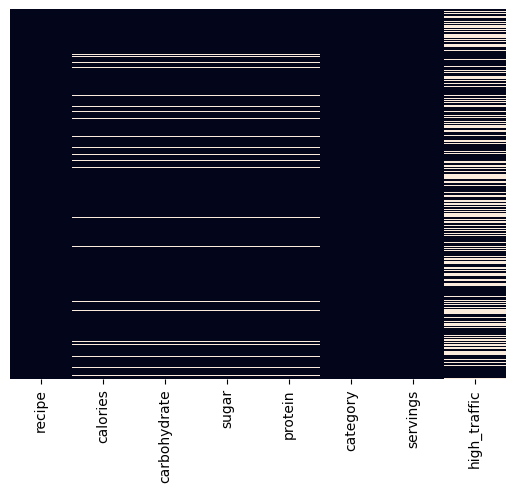

In [5]:
# Explore the missing values
print(df.isna().sum())
sns.heatmap(df.isnull(),yticklabels= False,cbar = False)

plt.savefig('images/heatmap.png')

In [6]:
# function displaying the unique values in the categorical and binary columns

def printunique(columns):
    for c in columns:
        print (df[c].unique())

columns = ['category', 'servings', 'high_traffic']

printunique(columns)

['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']
['6' '4' '1' '2' '4 as a snack' '6 as a snack']
['High' nan]


In [7]:
# Substitute the values in 'category' column
mapping = {'Chicken Breast': 'Chicken'}
df['category'] = df['category'].replace(mapping)
df['category'].unique()




array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert'],
      dtype=object)

In [8]:
# Substitute the values in 'servings' column and change the datatype
mapping = {'4 as a snack': '4', '6 as a snack': '6'}
df['servings'] = df['servings'].replace(mapping)
df['servings'].unique()
df['servings'] = df['servings'].astype('int')

In [11]:
# Substitute the values in 'high traffic' column and change the datatype
df['high_traffic'] = df['high_traffic'].fillna('0')
df['high_traffic'].replace('High', '1')
df['high_traffic'] = df['high_traffic'].astype('int')


# Verify the unique values and datatype
print(df['high_traffic'].unique())
print(df['high_traffic'].dtype)

[1 0]
int32


In [12]:
# dropping observations with missing values
df.dropna(subset = ['calories', 'carbohydrate', 'sugar', 'protein'], inplace = True)

Exploratory Data Analysis

Examing the distribution of numeric values

In [13]:
df.iloc[:,1:-3].describe()

,calories,carbohydrate,sugar,protein
count,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296
std,453.020997,43.949032,14.679176,36.369739
min,0.140000,0.030000,0.010000,0.000000
25%,110.430000,8.375000,1.690000,3.195000
50%,288.550000,21.480000,4.550000,10.800000
75%,597.650000,44.965000,9.800000,30.200000
max,3633.160000,530.420000,148.750000,363.360000


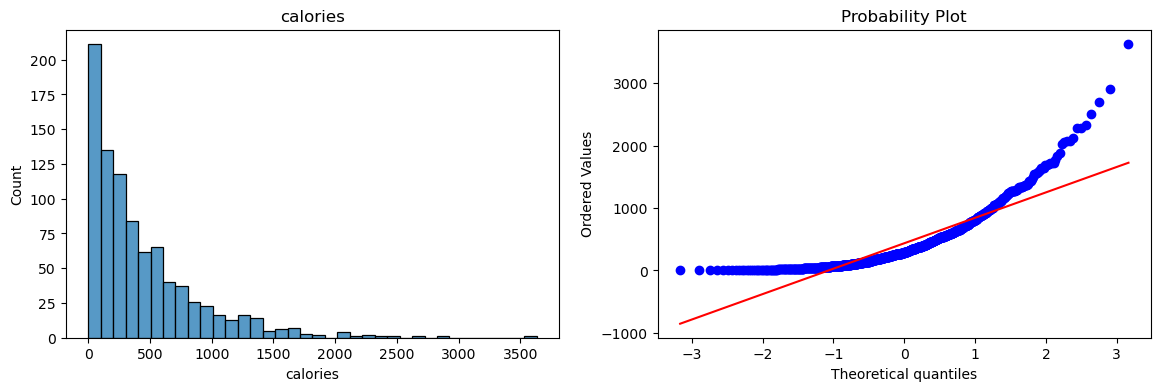

<Figure size 640x480 with 0 Axes>

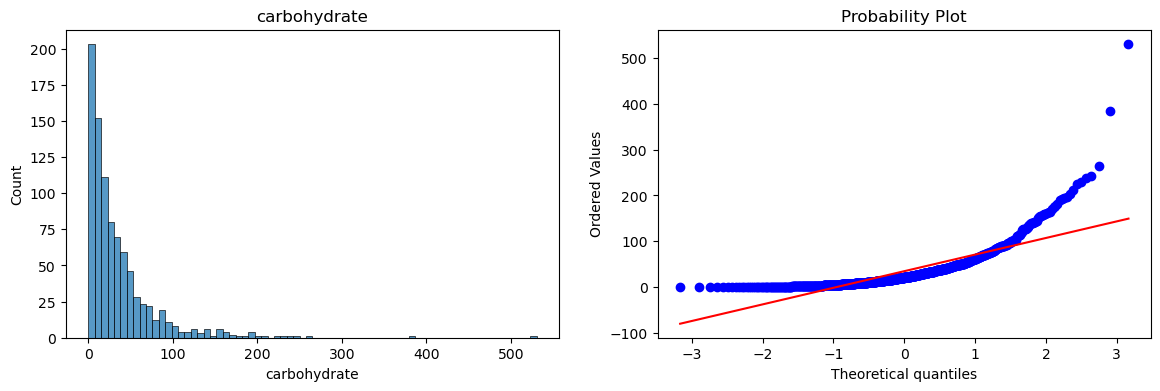

<Figure size 640x480 with 0 Axes>

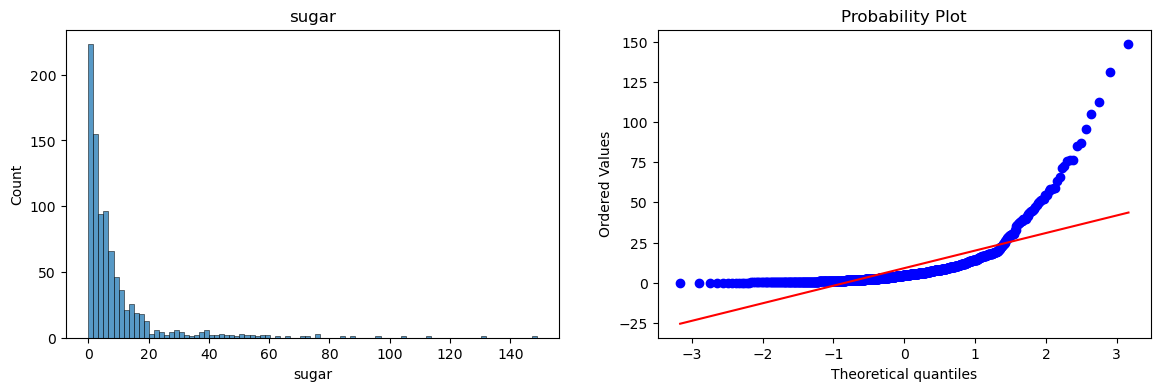

<Figure size 640x480 with 0 Axes>

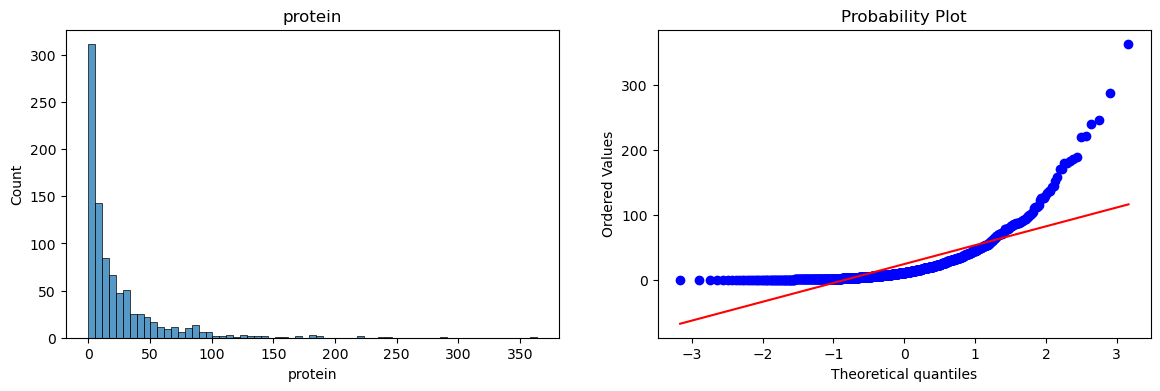

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
for i in df.iloc[:,[1,2,3,4,7]].columns:
    if(i != 'high_traffic'):
        plt.figure(figsize = (14,4))
        plt.subplot(1,2,1)
        #the figure has 1 row, 2 columns, and this plot is the first (1) plot.
        sns.histplot(x =df[i])
        plt.title(i)

        plt.subplot(1,2,2)
        #the figure has 1 row, 2 columns, and this plot is the second (2) plot.
        stats.probplot(x =df[i], dist ='norm', plot = plt)
    plt.show()

    plt.savefig('images/numeric_histplot.png')


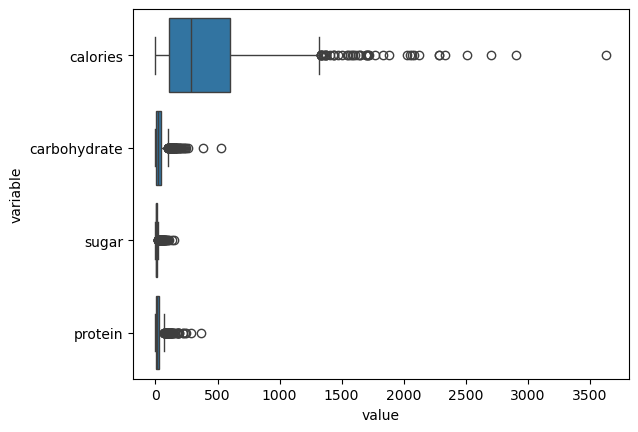

In [16]:
sns.boxplot(y="variable", x="value",
            data=pd.melt(df.iloc[:,[1,2,3,4]]))
plt.savefig('images/sns_boxplot.png')


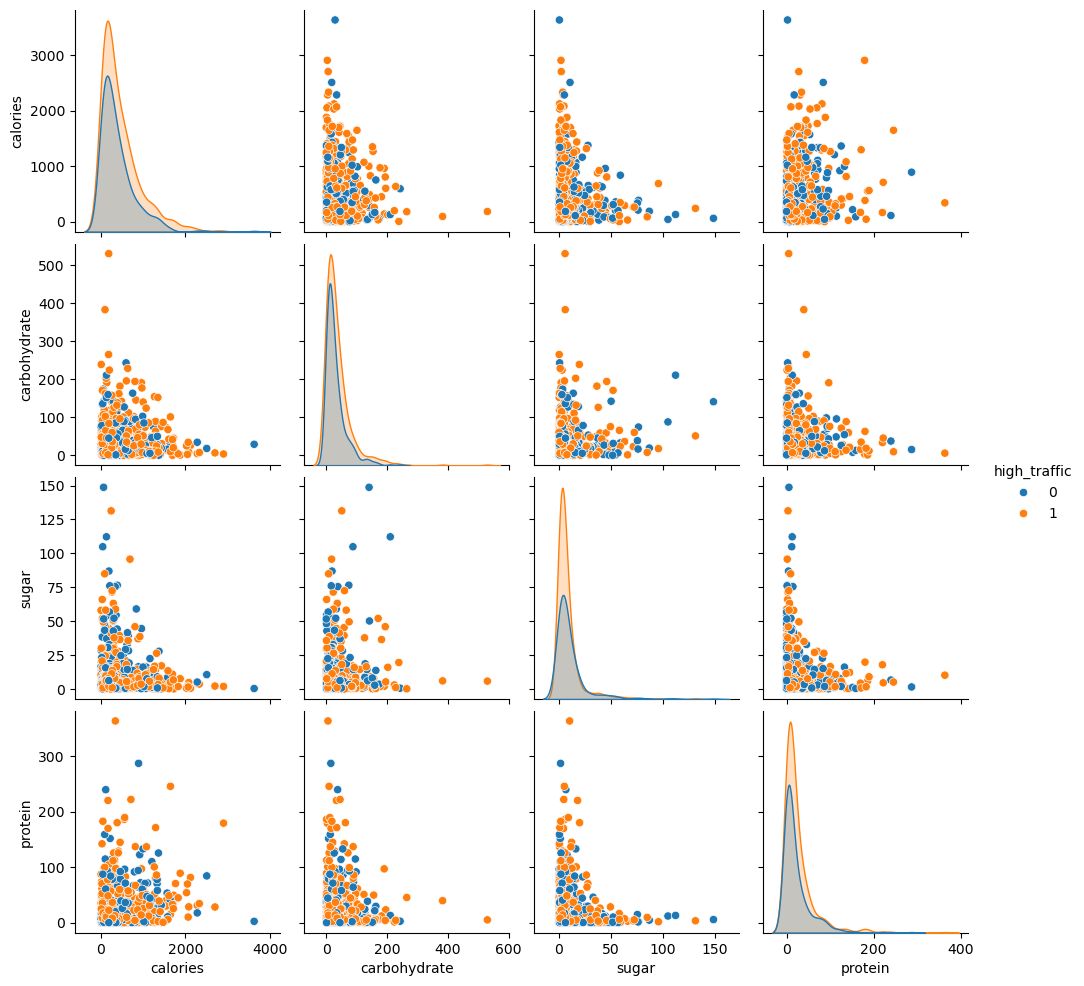

In [17]:
sns.pairplot(df.iloc[:,[1,2,3,4,7]], hue = 'high_traffic')
plt.savefig('images/sns_pairplot.png')

In [18]:
for col in ['calories', 'carbohydrate', 'sugar',  'protein']:
    q75,q25 = np.percentile(df.loc[:,col],[75,25])
    intr_qr = q75-q25
    max = q75+(3*intr_qr)
    min = q25-(3*intr_qr)
    df.loc[df[col] < min,col] = -10000
    df.loc[df[col] > max,col] = 10000


df = df[(df['calories']!=10000)  & ((df['carbohydrate']!=10000) & (df['sugar']!=10000)) & (df['protein']!=10000) ]
df.shape

(786, 8)

high_traffic
1    466
0    320
Name: count, dtype: int64

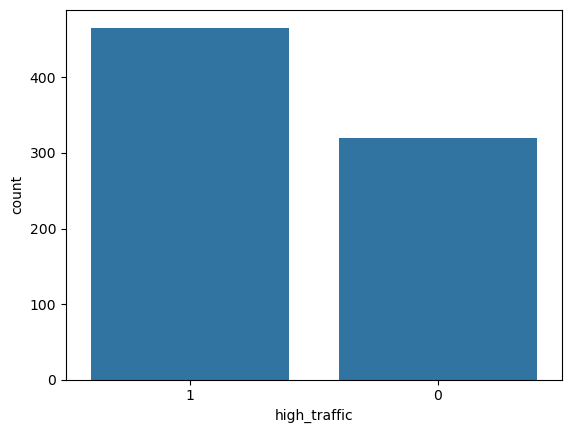

In [19]:
# plot showing the number of observations in each class
sns_cp = sns.countplot(x= 'high_traffic', data = df, order = df['high_traffic'].value_counts().index)
plt.savefig('images/sns_hightraffic_countplot.png')
df['high_traffic'].value_counts()

high_traffic
1    466
0    320
Name: count, dtype: int64

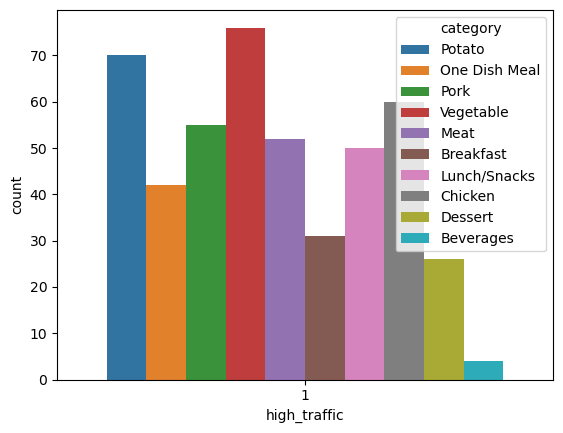

In [20]:
sns_cp = sns.countplot(x= 'high_traffic', hue = 'category', data = df[df['high_traffic']==1])

plt.savefig('images/sns_hightraffic_countplot.png')
df['high_traffic'].value_counts()

servings
4    325
6    158
2    152
1    151
Name: count, dtype: int64

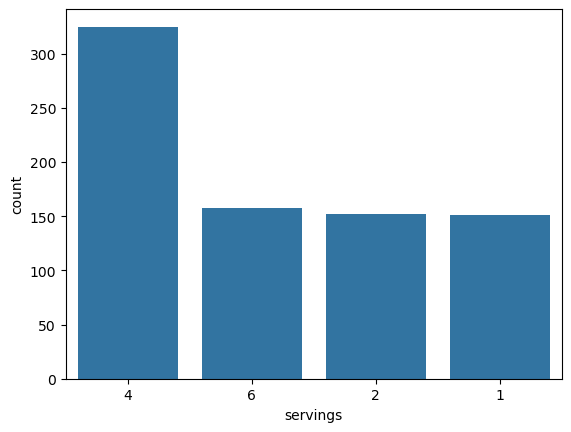

In [21]:

# plot showing the number of servings
sns_cp = sns.countplot(x= 'servings', data = df, order = df['servings'].value_counts().index)
plt.savefig('images/sns_servings_countplot.png')
df['servings'].value_counts()

Examining the correlation between numeric values

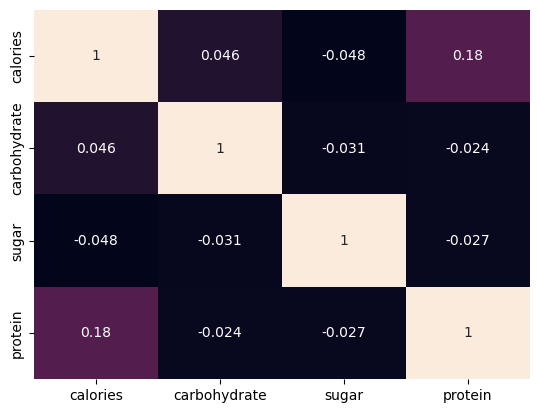

In [22]:
sns.heatmap(df.iloc[:,[1,2,3,4]].corr(),annot= True, cbar = False)
plt.savefig('images/sns_heatmap1.png')

Methodology

In [23]:
# splitting data
X = df.drop('high_traffic', axis =1)
columns = X.columns
y = df['high_traffic']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 123)

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 589 entries, 272 to 100
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        589 non-null    int64  
 1   calories      589 non-null    float64
 2   carbohydrate  589 non-null    float64
 3   sugar         589 non-null    float64
 4   protein       589 non-null    float64
 5   category      589 non-null    object 
 6   servings      589 non-null    int32  
dtypes: float64(4), int32(1), int64(1), object(1)
memory usage: 34.5+ KB


In [25]:
# perform power transformation and standardardization
pt = PowerTransformer()
std_scaler = StandardScaler()

X_train_06 = X_train.iloc[:,[0,6]]
X_train_1234 = pd.DataFrame(data =std_scaler.fit_transform(pt.fit_transform(X_train.iloc[:,[1,2,3,4]])),columns = X_train.iloc[:,[1,2,3,4]].columns)

# test set
X_test_06 = X_test.iloc[:,[0,6]]
X_test_1234 = pd.DataFrame(data =std_scaler.fit_transform(pt.fit_transform(X_test.iloc[:,[1,2,3,4]])),columns = X_test.iloc[:,[1,2,3,4]].columns)


In [26]:
# Encode the categorical variable
X_train_dummies = pd.get_dummies(X_train['category'], drop_first= True)
X_train = pd.concat([X_train_1234.reset_index(drop=True), X_train_dummies.reset_index(drop=True), X_train_06.reset_index(drop=True)], axis = 1)

X_test_dummies = pd.get_dummies(X_test['category'], drop_first= True)
X_test = pd.concat([X_test_1234.reset_index(drop=True), X_test_dummies.reset_index(drop=True), X_test_06.reset_index(drop=True)], axis = 1)

Logistic Regression

In [46]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear']}

logistic = LogisticRegression(random_state=123)
model = RandomizedSearchCV(estimator=logistic, param_distributions=param_grid)
model.fit(X_train, y_train)

print("Best Estimator:")
print(model.best_estimator_)
print("\nCoefficients:")
print(model.best_estimator_.coef_)
print("\nIntercept:")
print(model.best_estimator_.intercept_)

logistic_best_pred = model.best_estimator_.predict(X_test)
logistic_best_pred_probs = model.best_estimator_.predict_proba(X_test)[:, 1]


Best Estimator:
LogisticRegression(C=10, penalty='l1', random_state=123, solver='liblinear')

Coefficients:
[[ 2.69779773e-02 -8.61261831e-02 -8.40309729e-02 -7.73931959e-02
   1.88884251e+00  2.25968017e+00  3.16193366e+00  3.45977528e+00
   3.88832800e+00  3.55206562e+00  4.33357052e+00  5.25870065e+00
   6.54535466e+00 -4.57024466e-04  3.06962823e-02]]

Intercept:
[-2.48821466]


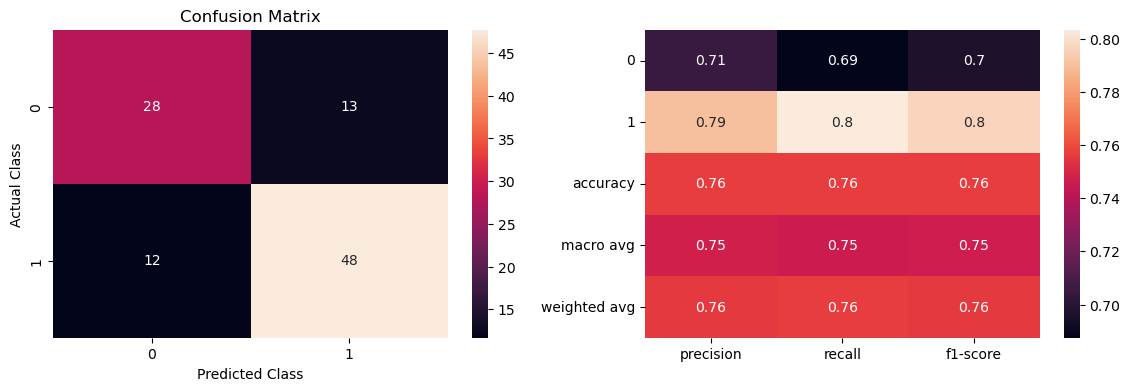

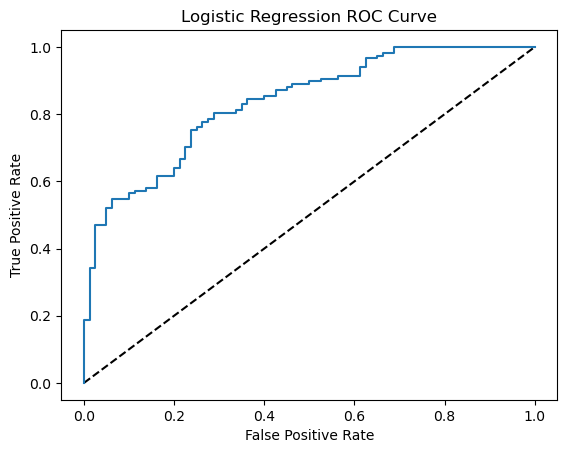

auc_score is: 0.8351495726495726


In [47]:
con_mat = confusion_matrix(y_test,logistic_best_pred)
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.heatmap(con_mat/np.sum(con_mat)*100,annot =True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

plt.subplot(1,2,2)
sns.heatmap(pd.DataFrame(classification_report(y_test,logistic_best_pred,output_dict=True)).T.iloc[:,:-1], annot = True)
plt.savefig('images/sns_heatmaplogreg.png')
plt.show()

# plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logistic_best_pred_probs)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.savefig('images/Roc_curvelogreg.png')
plt.show()

# roc_auc_score
print('auc_score is:', roc_auc_score(y_test, logistic_best_pred_probs))

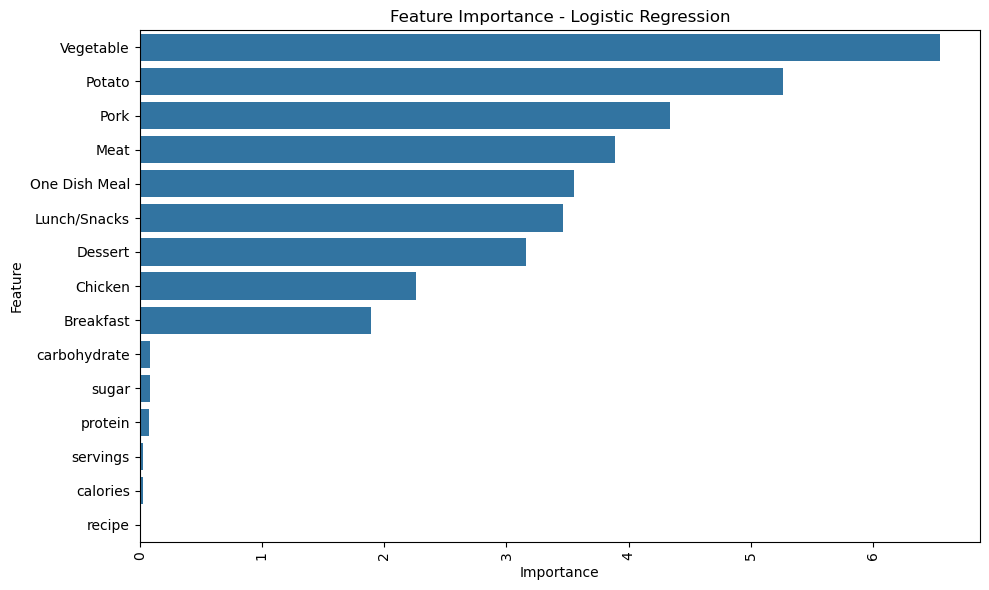

In [48]:
columns = X_train.columns
coefficients = np.abs(model.best_estimator_.coef_[0])

feature_importance_df = pd.DataFrame({'Feature': columns, 'Importance': coefficients})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance - Logistic Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('images/feature_importancelogreg.png')
plt.show()


Random Forest Classifier

In [41]:
param_grid = {'max_depth': [2, 4,6],
               'max_features': ['log2', 'sqrt'],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [20]}

rfc = RandomForestClassifier()
model = RandomizedSearchCV(estimator = rfc, param_distributions = param_grid, random_state = 123)
model.fit(X_train,y_train)
feature_importances= model.best_estimator_.feature_importances_
rfc_best_pred = model.best_estimator_.predict(X_test)
rfc_best_pred_probs = model.best_estimator_.predict_proba(X_test)[:,1]

print(model.best_estimator_)
print(feature_importances)

RandomForestClassifier(max_depth=6, min_samples_leaf=6, min_samples_split=5,
                       n_estimators=20)
[0.09736085 0.07389753 0.08552851 0.22890312 0.11970739 0.07352325
 0.00441707 0.00376483 0.01899312 0.00220912 0.01537584 0.06661645
 0.11624045 0.07205969 0.02140278]


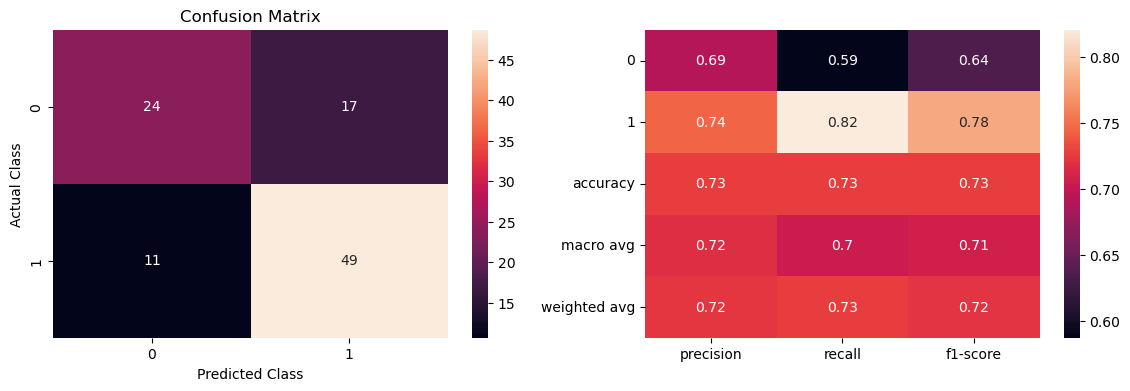

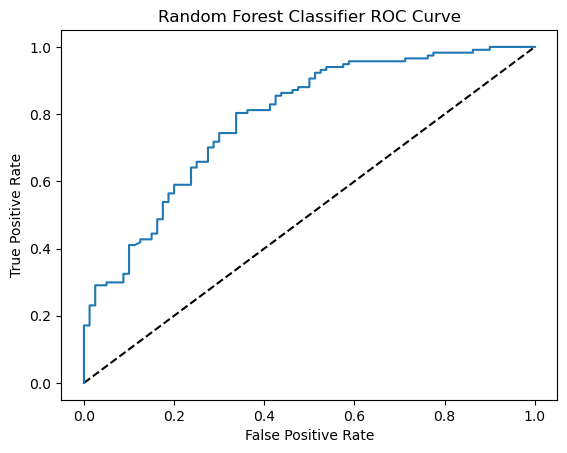

auc_score is: 0.7873397435897436


In [42]:
con_mat = confusion_matrix(y_test,rfc_best_pred)
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.heatmap(con_mat/np.sum(con_mat)*100,annot =True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

plt.subplot(1,2,2)
sns.heatmap(pd.DataFrame(classification_report(y_test,rfc_best_pred,output_dict=True)).T.iloc[:,:-1], annot = True)
plt.savefig('images/sns_heatmaprandforest.png')
plt.show()

# plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rfc_best_pred_probs)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier ROC Curve')
plt.savefig('images/ROC_curverandforest.png')
plt.show()

# roc_auc_score
print('auc_score is:', roc_auc_score(y_test, rfc_best_pred_probs))


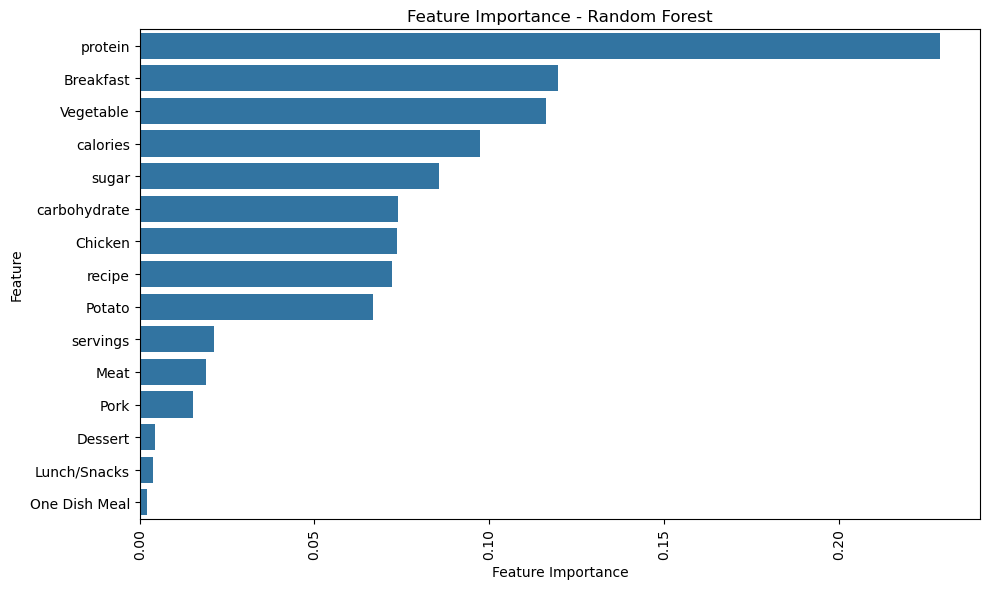

In [ ]:
columns = X_train.columns
feat_imp = pd.DataFrame({'Feature': columns, 'Feature Importance': feature_importances})
feat_imp.sort_values(by='Feature Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Feature Importance', y='Feature', data=feat_imp)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('images/feature_importancerandforest.png')
plt.show()


K-Nearest Neighbors (KNN)

In [56]:
# K-nearest neighbors (KNN)

param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
knn = KNeighborsClassifier()
model_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn)
model_knn.fit(X_train, y_train)
knn_best_estimator = model_knn.best_estimator_
knn_best_pred = knn_best_estimator.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_best_pred)

# Evaluate the performance of KNN
print("Accuracy (KNN):", knn_accuracy)


Accuracy (KNN): 0.5583756345177665


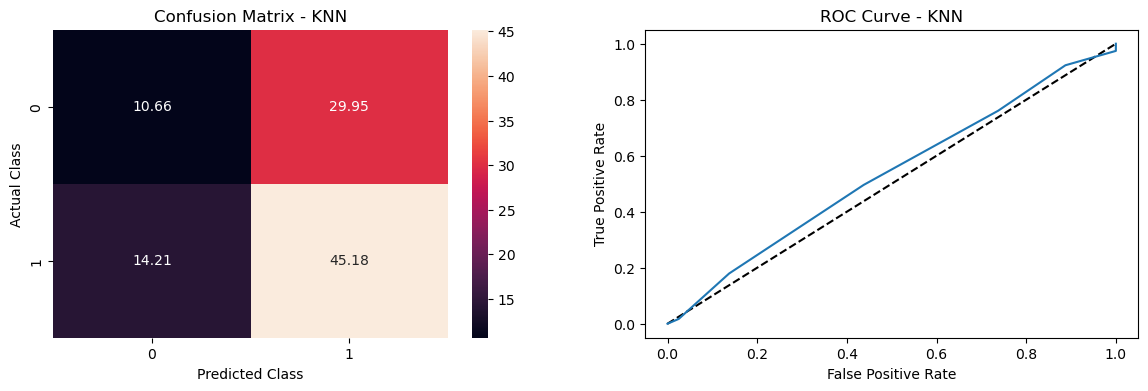

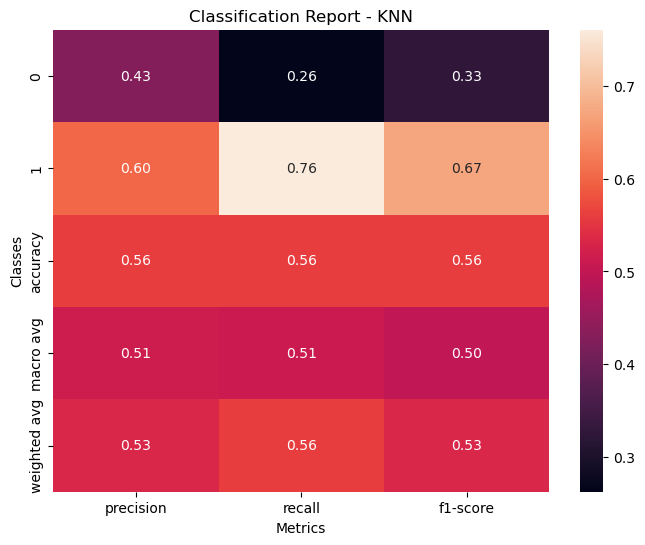

AUC Score (KNN): 0.5340277777777778


In [57]:
# K-nearest neighbors (KNN)
knn_con_mat = confusion_matrix(y_test, knn_best_pred)
knn_classification_report = classification_report(y_test, knn_best_pred)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_best_pred_probs)
knn_auc = roc_auc_score(y_test, knn_best_pred_probs)

# Plotting Confusion Matrix and ROC curve for KNN
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
sns.heatmap(knn_con_mat / np.sum(knn_con_mat) * 100, annot=True, fmt=".2f")
plt.title('Confusion Matrix - KNN')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

plt.subplot(1, 2, 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(knn_fpr, knn_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.savefig('images/confusion_matrix_knn.png')
plt.savefig('images/roc_curve_knn.png')
plt.show()

# Classification report
knn_classification_report_dict = classification_report(y_test, knn_best_pred, output_dict=True)
knn_classification_report_df = pd.DataFrame(knn_classification_report_dict).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(knn_classification_report_df.iloc[:, :-1], annot=True, fmt='.2f')
plt.title('Classification Report - KNN')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig('images/classification_report_knn.png')
plt.show()

# Calculate ROC AUC score for KNN
knn_auc_score = roc_auc_score(y_test, knn_best_pred_probs)
print("AUC Score (KNN):", knn_auc_score)

Support Vector Machine Classification

In [77]:
# Support Vector Machines (SVM)
svm = SVC(probability=True)
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
model_svm = RandomizedSearchCV(estimator=svm, param_distributions=param_grid_svm, random_state=123)
model_svm.fit(X_train, y_train)
svm_best_estimator = model_svm.best_estimator_
svm_best_pred = svm_best_estimator.predict(X_test)
svm_best_pred_probs = svm_best_estimator.predict_proba(X_test)[:, 1]

c:\Users\cerde\projects\Recipes\recipesenv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


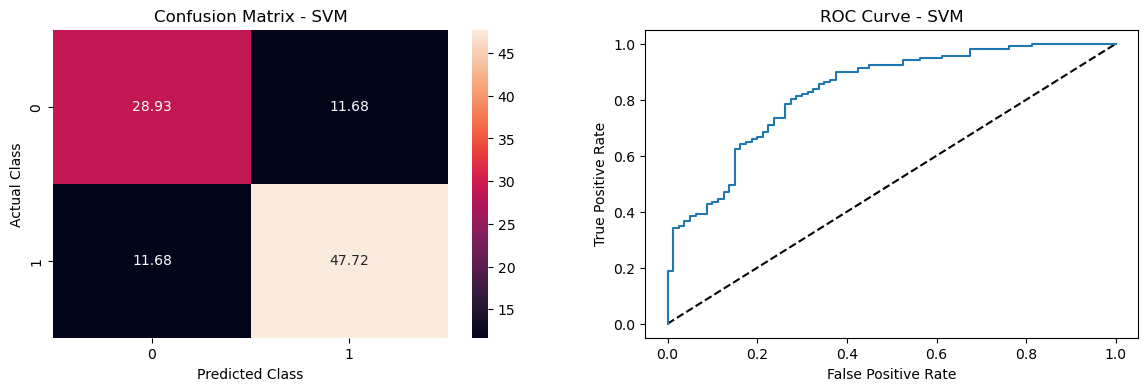

AUC Score (SVM): 0.830982905982906


In [78]:
# Support Vector Machines (SVM)
svm_con_mat = confusion_matrix(y_test, svm_best_pred)
svm_classification_report = classification_report(y_test, svm_best_pred)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_best_pred_probs)
svm_auc = roc_auc_score(y_test, svm_best_pred_probs)

# Plotting Confusion Matrix and ROC curve for SVM
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
sns.heatmap(svm_con_mat / np.sum(svm_con_mat) * 100, annot=True, fmt=".2f")
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

plt.subplot(1, 2, 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(svm_fpr, svm_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.savefig('images/confusion_matrix_svm.png')
plt.savefig('images/roc_curve_svm.png')
plt.show()

# Calculate ROC AUC score for KNN
svm_auc_score = roc_auc_score(y_test, svm_best_pred_probs)
print("AUC Score (SVM):", svm_auc_score)

Gradient Boosting Classification

In [60]:
# Gradient Boosting
gradient_boosting = GradientBoostingClassifier()
param_grid_gb = {'max_depth': [2, 4, 6], 'max_features': ['log2', 'sqrt'],
                 'min_samples_leaf': [4, 6, 8], 'min_samples_split': [5, 7, 10],
                 'n_estimators': [20]}
model_gb = RandomizedSearchCV(estimator=gradient_boosting, param_distributions=param_grid_gb, random_state=123)
model_gb.fit(X_train, y_train)
gb_best_estimator = model_gb.best_estimator_
gb_best_pred = gb_best_estimator.predict(X_test)
gb_best_pred_probs = gb_best_estimator.predict_proba(X_test)[:, 1]


# Obtain the classification report as a dictionary
gb_classification_report_dict = classification_report(y_test, gb_best_pred, output_dict=True)
# Convert the classification report dictionary to a DataFrame
gb_classification_report_df = pd.DataFrame(gb_classification_report_dict).transpose()


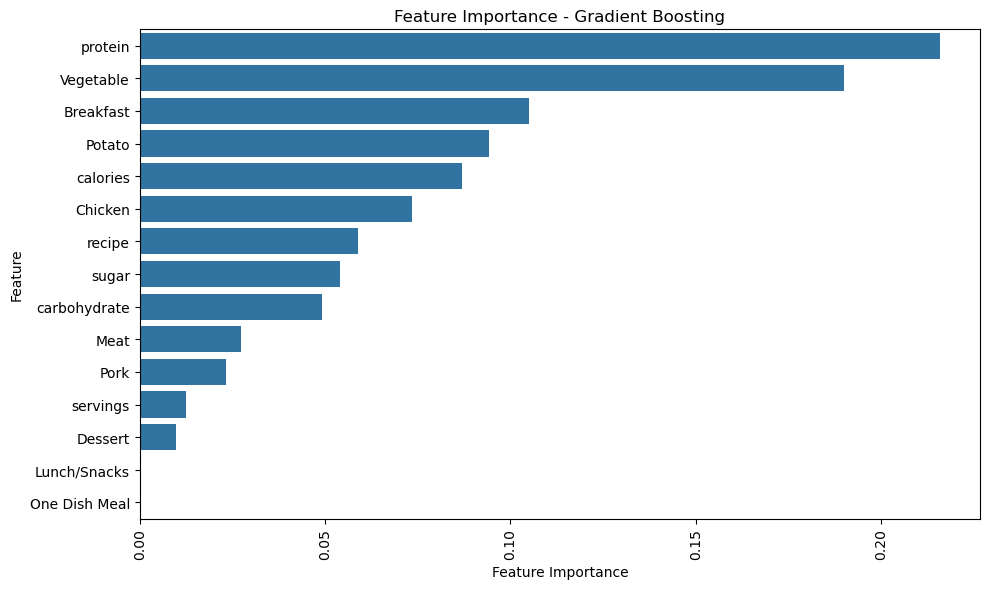

In [63]:
# Plotting Feature Importances for Gradient Boosting
columns = X_train.columns
gb_feature_importances = model_gb.best_estimator_.feature_importances_
feat_imp_gb = pd.DataFrame({'Feature': columns, 'Feature Importance': gb_feature_importances})
feat_imp_gb.sort_values(by='Feature Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Feature Importance', y='Feature', data=feat_imp_gb)
plt.title('Feature Importance - Gradient Boosting')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('images/feature_importance_gb.png')
plt.show()

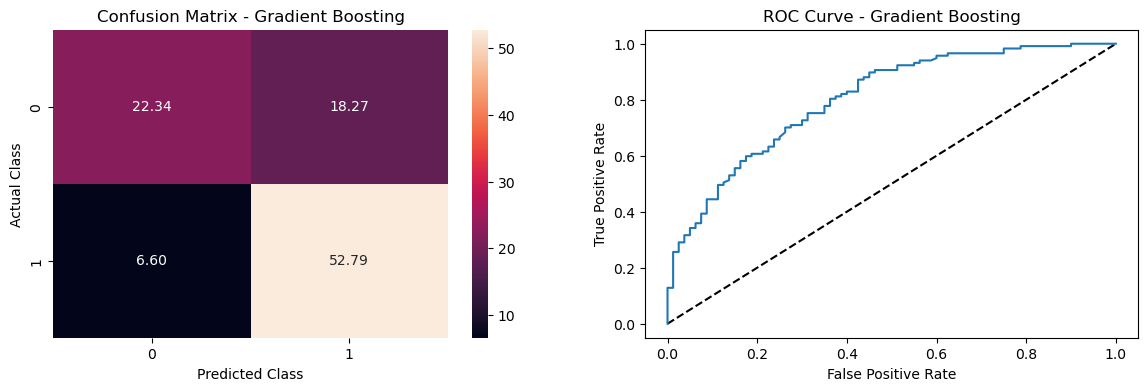

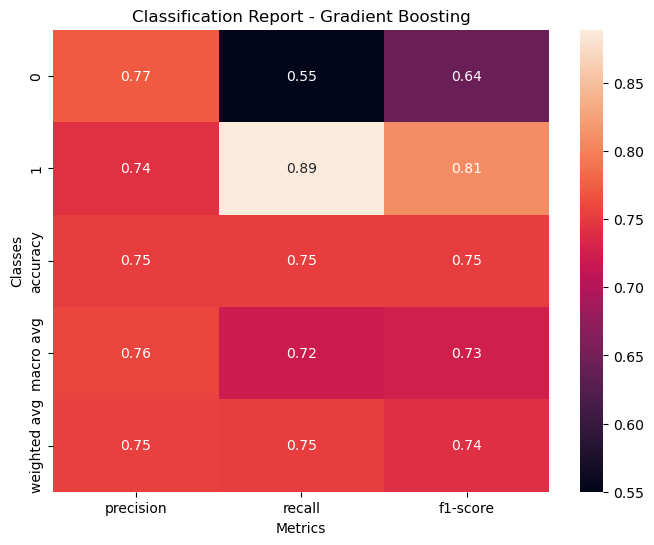

AUC Score (GB): 0.8032051282051282


In [64]:
# Confusion matrix and classification report for Gradient Boosting
gb_con_mat = confusion_matrix(y_test, gb_best_pred)
gb_classification_report = classification_report(y_test, gb_best_pred)

# ROC curve and AUC score for Gradient Boosting
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_best_pred_probs)
gb_auc = roc_auc_score(y_test, gb_best_pred_probs)

# Plotting Confusion Matrix and ROC curve for Gradient Boosting
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
sns.heatmap(gb_con_mat / np.sum(gb_con_mat) * 100, annot=True, fmt=".2f")
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

plt.subplot(1, 2, 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(gb_fpr, gb_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')

plt.savefig('images/gb_confusion_matrix_roc_curve.png')
plt.show()


# Plot the classification report heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(gb_classification_report_df.iloc[:, :-1], annot=True, fmt='.2f')
plt.title('Classification Report - Gradient Boosting')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig('images/classification_report_gb.png')
plt.show()

gb_auc_score = roc_auc_score(y_test, gb_best_pred_probs)
print("AUC Score (GB):", gb_auc_score)

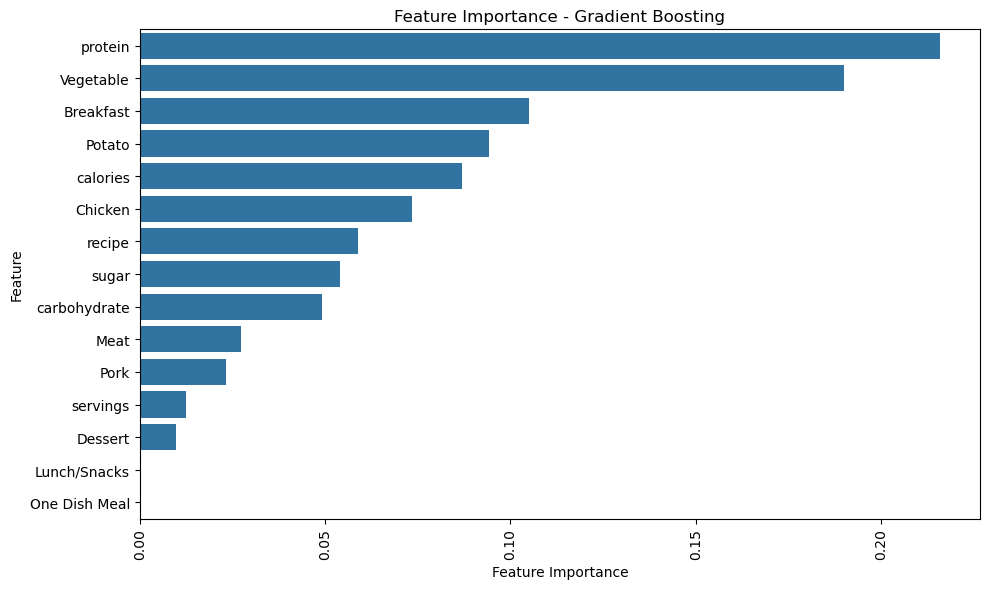

In [65]:
# Plotting Feature Importances for Gradient Boosting
gb_feature_importances = gb_best_estimator.feature_importances_
columns = X_train.columns
feat_imp_gb = pd.DataFrame({'Feature': columns, 'Feature Importance': gb_feature_importances})
feat_imp_gb.sort_values(by='Feature Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Feature Importance', y='Feature', data=feat_imp_gb)
plt.title('Feature Importance - Gradient Boosting')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('images/feature_importance_gb.png')
plt.show()

Neural Network Classification

In [66]:
# Neural Networks
nn = MLPClassifier()
param_grid_nn = {'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                 'activation': ['relu', 'logistic'], 'alpha': [0.001, 0.01, 0.1]}
nn = MLPClassifier(max_iter = 500)
model_nn = RandomizedSearchCV(estimator=nn, param_distributions=param_grid_nn, random_state=123)
model_nn.fit(X_train, y_train)
nn_best_estimator = model_nn.best_estimator_
nn_best_pred = nn_best_estimator.predict(X_test)
nn_best_pred_probs = nn_best_estimator.predict_proba(X_test)[:, 1]

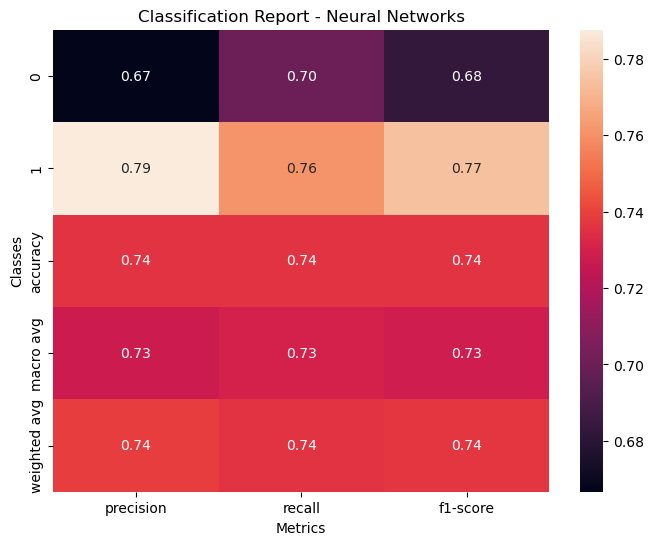

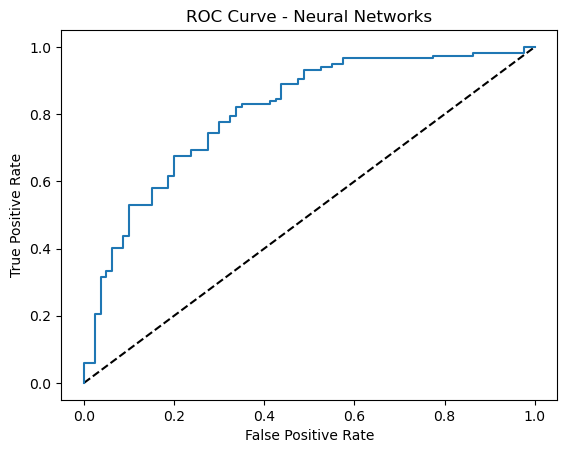

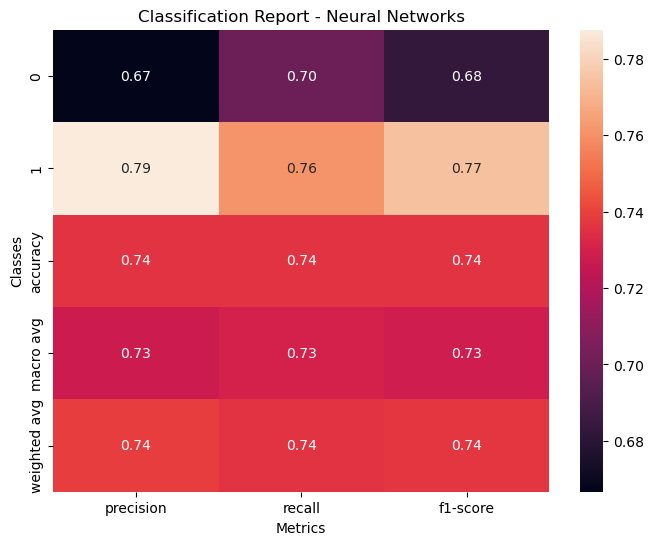

AUC Score (NN): 0.8068376068376069


In [67]:
# Neural Networks
nn_classification_report_dict = classification_report(y_test, nn_best_pred, output_dict=True)
nn_classification_report_df = pd.DataFrame(nn_classification_report_dict).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(nn_classification_report_df.iloc[:, :-1], annot=True, fmt='.2f')
plt.title('Classification Report - Neural Networks')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig('images/classification_report_nn.png')
plt.show()

# ROC curve for Neural Networks
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_best_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(nn_fpr, nn_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Networks')
plt.savefig('images/roc_curve_nn.png')
plt.show()

# Plot the classification report heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(nn_classification_report_df.iloc[:, :-1], annot=True, fmt='.2f')
plt.title('Classification Report - Neural Networks')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig('images/classification_report_nn.png')
plt.show()

nn_auc_score = roc_auc_score(y_test, nn_best_pred_probs)
print("AUC Score (NN):", nn_auc_score)

In [79]:

# Define the list of models
models = ['Logistic Regression', 'Random Forest', 'K-Nearest Neighbor', 'Support Vector Machine', 'Gradient Boosting', 'Neural Network']

# Define the list of metrics
metrics = ['Precision', 'Accuracy', 'Recall', 'F1 Score', 'ROC AUC Score']

# Initialize an empty DataFrame
results_df = pd.DataFrame(columns=metrics, index=models)

# Calculate and store the metrics for each model
for model in models:
    if model == 'Logistic Regression':
        # Calculate the metrics for Logistic Regression
        precision = precision_score(y_test, logistic_best_pred)
        accuracy = accuracy_score(y_test, logistic_best_pred)
        recall = recall_score(y_test, logistic_best_pred)
        f1 = f1_score(y_test, logistic_best_pred)
        roc_auc = roc_auc_score(y_test, logistic_best_pred_probs)
    elif model == 'Random Forest':
        # Calculate the metrics for Random Forest
        precision = precision_score(y_test, rfc_best_pred)
        accuracy = accuracy_score(y_test, rfc_best_pred)
        recall = recall_score(y_test, rfc_best_pred)
        f1 = f1_score(y_test, rfc_best_pred)
        roc_auc = roc_auc_score(y_test, rfc_best_pred_probs)
    elif model == 'K-Nearest Neighbor':
        # Calculate the metrics for K-Nearest Neighbor
        precision = precision_score(y_test, knn_best_pred)
        accuracy = accuracy_score(y_test, knn_best_pred)
        recall = recall_score(y_test, knn_best_pred)
        f1 = f1_score(y_test, knn_best_pred)
        roc_auc = roc_auc_score(y_test, knn_best_pred_probs)
    elif model == 'Support Vector Machine':
        # Calculate the metrics for Support Vector Machine
        precision = precision_score(y_test, svm_best_pred)
        accuracy = accuracy_score(y_test, svm_best_pred)
        recall = recall_score(y_test, svm_best_pred)
        f1 = f1_score(y_test, svm_best_pred)
        roc_auc = roc_auc_score(y_test, svm_best_pred_probs)
    elif model == 'Gradient Boosting':
        # Calculate the metrics for Gradient Boosting
        precision = precision_score(y_test, gb_best_pred)
        accuracy = accuracy_score(y_test, gb_best_pred)
        recall = recall_score(y_test, gb_best_pred)
        f1 = f1_score(y_test, gb_best_pred)
        roc_auc = roc_auc_score(y_test, gb_best_pred_probs)
    elif model == 'Neural Network':
        # Calculate the metrics for Neural Network
        precision = precision_score(y_test, nn_best_pred)
        accuracy = accuracy_score(y_test, nn_best_pred)
        recall = recall_score(y_test, nn_best_pred)
        f1 = f1_score(y_test, nn_best_pred)
        roc_auc = roc_auc_score(y_test, nn_best_pred_probs)

    # Store the metrics in the DataFrame
    results_df.loc[model] = [precision, accuracy, recall, f1, roc_auc]

# Display the results
print(results_df)


                       Precision  Accuracy    Recall  F1 Score ROC AUC Score
Logistic Regression     0.789916  0.756345  0.803419   0.79661       0.83515
Random Forest           0.744186  0.725888  0.820513  0.780488       0.78734
K-Nearest Neighbor      0.601351  0.558376  0.760684  0.671698      0.534028
Support Vector Machine  0.803419  0.766497  0.803419  0.803419      0.830983
Gradient Boosting       0.742857  0.751269  0.888889  0.809339      0.803205
Neural Network          0.787611  0.736041  0.760684  0.773913      0.806838


Based on these metrics, we can draw the following conclusions:

Logistic Regression, Support Vector Machine, and Neural Network have the highest precision, indicating a higher proportion of correct positive predictions.
Random Forest shows relatively high accuracy but lower precision compared to Logistic Regression, SVM, and Neural Network.
K-Nearest Neighbors (KNN) has the lowest precision and accuracy among the models evaluated.
Gradient Boosting demonstrates a good balance between precision, accuracy, and recall.
The ROC AUC scores provide an overall measure of the model's ability to discriminate between positive and negative instances. Logistic Regression and Gradient Boosting have the highest ROC AUC scores, indicating better performance in this aspect.

Overall, logistic Regression demonstrates consistent performance across precision, accuracy, recall, F1 score, and ROC AUC score. It achieves a high precision, indicating a good proportion of correct positive predictions, and a high ROC AUC score, indicating its ability to discriminate between positive and negative instances effectively.

Additionally, Logistic Regression provides competitive accuracy and recall values, implying a good balance between overall correct predictions and capturing true positive instances.